In [4]:
import numpy as np
import math
from scipy.stats import norm, gamma, poisson
import operator
import pandas as pd
import sys
from functools import reduce
import time

In [2]:
SeattleA = np.array([[15,12,4],[11,17,4],[0,21,4],[0,0,5]])

In [5]:
def thresH(n):
    thres = np.repeat(0.0,n-1)
    thres[0] = np.random.exponential(size=1,scale=1/(n-1))
    if n > 2:
        for i in range(1,n-1):
            thres[i] = thres[i-1] + np.random.exponential(size=1, scale=1/(n-i))
    
    return thres

def PCOUP(Xdata, epss, k, run):
    """Partially coupled ABC algorithm to obtain run accepted values."""
     #initialize empty zero array
    output = np.zeros(((2*epss[1]+1)*run, 5), dtype = float)
    simcount=0
    count=0
    jj=0
    
    while jj<run:
        simcount+=1
        lambda_L = np.random.exponential(1,1) # Sample lambda_L
        J = House_COUP(Xdata,epss[1],lambda_L,k) # Run coupled simulations
        W = J[J[:,3]<J[:,4],:]        # W contains successful simulations (infect close to xA individuals)
        if W.size == 5:
            W = np.array(W).reshape((-1, 5))
        if W[:,0].size > 0:
            if min(W[:, 1])<=epss[0]:
                jj+=1
                for ii in range(W[:, 0].size):
                    if W[ii, 1]<=epss[0]:
                        count+=1
                        output[count-1,:]=np.r_[W[ii,1:5], lambda_L]
                        print(jj,count,simcount)
                        
    # Stores values from simulation - these include closeness of simulated epidemic 
    # to data, range of lambda_G values and lambda_L
    return {'OUTPUT':output[0:count,:], 'simcount':simcount}

def PCOUP_SMC(Xdata, epss, k, run, OX):
    """ Code for running SMC-ABC for partially coupled household epidemics"""
    #initialize empty zero array
    OUTPUT = np.zeros(((2*epss[1]+1)*run, 6), dtype = float)
    simcount=0
    count=0
    jj=0
    #Setting standard deviation for importance sampling
    VL = np.sum(OX[:,2]**2*OX[:,3])-np.sum(OX[:,2]*OX[:,3])**2
    sL = math.sqrt(2*VL)
    # Number of samples stored from run acceptances.
    cox = OX[:, 0].size
    
    while jj<run:
        simcount+=1
        LA = np.random.choice(cox, 1, p = OX[:,3]/OX[:,3].sum(), replace = True)[0]
        lambda_L = np.random.normal(OX[LA-1, 2], sL, 1)[0]
        if lambda_L>0:
            J=House_COUP(Xdata,epss[1],lambda_L,k) # Run coupled simulations
            W = J[J[:,3]<J[:, 4],:]# W contains successful simulations (infect close to xA individuals)
            if W.size == 5:
                W = np.array(W).reshape((-1, 5))
            if W[:,0].size>0:
                if  min(W[:, 1])<=epss[0]:
                    jj+=1
                    for ii in range(W[:,0].size):
                        if W[ii, 1]<=epss[0]:
                            count+=1
                            OUTPUT[count-1,:] = np.r_[W[ii, 1:5], lambda_L, np.exp(-lambda_L)/sum(norm.pdf(lambda_L, OX[:,2], sL))]
            
        
    return {'OUTPUT':OUTPUT[0:count,:], 'simcount':simcount}

def House_COUP(Xdata,epsil,lambda_L,k):
    """Partially coupled ABC algorithm for household epidemics
    lambda_L is drawn from the prior (or however)
    Code finds lambda_G values consistent with the data
    Input: Xdata - Epidemic data to compare simulations with.
    epsil - Max distance between simulated and observed final size for a simulation 
    to be accepted. (Tighter control on distance after simulations straightforward).
    lambda_L - local infection (household) rate
    k - Gamma(k,k) infectious period with k=0 a constant infectious period."""
    hsA = np.sum(Xdata, axis = 0) # hsA[i] - Number of households of size i
    isA = np.sum(Xdata, axis = 1) # isA[i] - Number of households with i-1 infectives
    colA = np.arange(1, hsA.shape[0]+1)
    rowA = np.arange(0, hsA.shape[0]+1)
    
    xA = np.sum(isA*rowA) # Final size
    HH = hsA.shape[0] # HH maximum household size
    ks = np.arange(1, HH+1)
    
    n = np.repeat(ks, hsA)
    m = n.shape[0]# Number of households
    N = np.sum(n) # Population size
    NS = N.copy() # Number of susceptibles
    sev=0       # Running tally of severity (sum of infectious periods)
    threshold=0 # Running tally of (global) threshold required for the next infection
    
    ni = np.repeat(0, n.size) # infectives (per household)
    ns = n.copy() # susceptibles (per household)
    
    OUT = np.zeros((HH+1, HH))
    OUT[0, :] = hsA # Epidemic data in the same form as Xdata
                   # Start with everybody susceptible
    
    DISS = np.zeros((2*epsil+1, 5)) # Matrix for collecting epidemics infecting within epsil of xA infectives.
    SEVI = np.zeros((N, 3)) # Matrix to keep track of number of infectives, severity and threshold.
    ys=0    # number of infectives
    count=0 # number of global infections taking place. First global infection is the introductory case. 
    
    while ys<=(xA+epsil):
        # Only need to consider the epidemic until xA+epsil infections occur.
        # We simulate successive global infections (should they occur) with associated
        # local (within household epidemics)
        # For the count+1 global infection to take place, we require that 
        # for k=1,2,..., count;  lambda_G * severity from first k infectives is larger
        # than the k^th threshold
        count+=1
        kk = np.random.choice(m, 1, p = ns/ns.sum(), replace = True)[0]
        OUT[ni[kk-1],n[kk-1]-1]=OUT[ni[kk-1],n[kk-1]-1]-1
        hou_epi=House_epi(ns[kk-1],k,lambda_L)# Simulate a household epidemic among the remaining susceptibles in the household
        
        ns[kk-1]-=hou_epi[0]
        ni[kk-1] = n[kk-1] - ns[kk-1]#update household kk data (susceptibles and infectives)
        
        OUT[ni[kk-1],n[kk-1]-1]+=1# Update the state of the population following the global 
        #infection and resulting household epidemic
        NS = ns.sum()
        threshold+=np.random.exponential(size = 1, scale = (N/NS))
        
        ys+=hou_epi[0]
        sev+=hou_epi[1]
        if count<=N:
            SEVI[count-1,:] = [ys,sev,threshold]
        # If the number infected is close to xA, we check what value of lambda_G 
        # would be needed for an epidemic of the desired size. 
        # Note that in many cases no value of lambda_G will result in an epidemic 
        # close to xA. 
        if abs(ys-xA)<=epsil:
            dist = np.sum(abs(OUT-Xdata))
            TT = SEVI[0:count, 2]/SEVI[0:count, 1] #ratio of threshold to severity
            Tlow = max(TT[0:(count-1)])
            Thi=TT[0:count].max()   #  Thi is the maximum lambda_G which leads to at most count global infections
            DISS[ys-(xA-epsil), :] = [1,dist,abs(ys-xA),Tlow,Thi]
            
    return DISS

def process(DATA):
    hsA = np.sum(DATA,axis=0)
    isA = np.sum(DATA,axis=1)
    colA = np.array(range(1,len(hsA)+1))
    rowA = np.array(range(0,len(hsA)+1))
    
    xA = np.sum(isA*rowA) # Final size
    N = np.sum(hsA*colA) # Population size
    
    return hsA, isA, colA, rowA, xA, N

def House_SEL(hs, lambda_G, lambda_L, k):
    HH = hs.size
    ks = np.array(range(1,HH+1))

    n = np.repeat(ks,hs)

    m = n.size  # Number of households
    N = n.sum() # Population size
    NS = N

    sev = 0
    threshold = 0

    ni = np.repeat(0,m)
    ns = n.copy()

    R = np.random.exponential(size=N)

    while threshold <= lambda_G*sev:
        kk = np.random.choice(a=np.arange(m)+1, size = 1, replace = True, p = ns/(ns.sum()))[0]
        
        hou_epi = House_epi(ns[kk-1],k,lambda_L)
        ns[kk-1] = ns[kk-1] - hou_epi[0]
        sev = sev + hou_epi[1]
        
        ni[kk-1] = n[kk-1]-ns[kk-1] 
        #NS=NS-hou_epi[0]
        NS=ns.sum()
        
        if NS > 0:
            threshold = threshold + np.random.exponential(scale = N/NS, size=1)[0]
        if NS == 0:
            threshold = 2*lambda_G*sev
        
    OUT = np.zeros((HH+1,HH))
    for i in range(1, HH+2):
        for j in range(1,HH+1):
            OUT[i-1,j-1] = sum(n[ni==(i-1)]==j)
    
    return OUT
#
# Code for running vanilla ABC for households
#
def House_van(Xdata,epsil,k,run):
    """
    Xdata - a data set
    epsil - a numpy array of length 2
    k - int
    run - int
    """
    
    OUTPUT = np.zeros((run,2))
    hs = np.sum(Xdata,axis=0).astype('int')
    isB = np.sum(Xdata,axis=1)
    
    rowB = np.arange(hs.size+1)
    xB = sum(isB*rowB)
    
    simcount = 0
    j = 0
    
    while j<run:
        simcount = simcount+1
        lambda_G = np.random.exponential(size=1)
        lambda_L = np.random.exponential(size=1)
        J = House_SEL(hs,lambda_G,lambda_L,k)
        
        if ((abs(J-Xdata)).sum()) <= epsil[0]:
            isJ = np.sum(J, axis=1)
            if abs(sum(isJ*rowB)-xB) <= epsil[1]:
                j = j+1
                OUTPUT[j-1,] = np.array([lambda_G,lambda_L]).reshape((1,2))
                print(j,simcount)
                
    return {'OUTPUT': OUTPUT, 'simcount' : simcount}     

def House_epi(n,k,lambda_L):
    
    i=0
    sev=0
    
    if n == 1:
        i = 1
        if k == 0:
            sev = 1
        if k > 0:
            sev = np.random.gamma(k, 1/k, 1)
    
    if n > 1:
        t = thresH(n)
        if k == 0:
            q = np.repeat(1.0,n)
        if k > 0:
            q = np.random.gamma(size=n, shape=k, scale=1/k)
        t = np.r_[t, 2*lambda_L*q.sum()]
        
        i = 0
        test = 0
        while test == 0:
            i+= 1
            if t[i-1] > (lambda_L*np.sum(q[0:i])):
                test = 1 
                sev = np.sum(q[0:i])
                
    return i, sev
# Code for setting (local) thresholds in a household of size n.
# 
# Note local thresholds not required for households of size 1.
# Infection rate does not depend upon households size.
#

def Mexp(k,Lambda,U,a,b):
    """Moment calculator for Exp(\lambda) prior."""
    if k == 0:
        U+=math.exp(-a*Lambda)-math.exp(-Lambda*b)
    if k>0:
        U+=a**k*math.exp(-Lambda*a)-b**k*math.exp(-Lambda*b)+k/Lambda*Mexp((k-1), Lambda, U, a, b)
        
    return U


In [190]:
tstartC = time.time()

DATA=SeattleA


proc = process(DATA)
hsA, isA , colA, rowA,  xA , N = proc

#
# Set thresholds
#


#Eps1=c(100,70,50)
#Eps2=c(10,6,4)

Eps1= [20,12,8]
Eps2= [3,2,1]

TT=len(Eps1)
EpsM= np.vstack((Eps1, Eps2)).T


In [191]:
# Set infectious period (k) and  number of iterations (run)
k=0
run=10

#
# Set infectious period (k) and
# number of iterations (run)
#

OUTP=PCOUP(DATA,EpsM[0,:],k,run)
OUT = OUTP['OUTPUT']
simT = OUTP['simcount']
OL = np.zeros((OUT[:, 0].size,4))
temp = OUT[:,2:5]
OL[:,0:3] = temp
OL[:,3]=np.exp(-OUT[:,2])-np.exp(-OUT[:,3])
OL[:,3]=OL[:,3]/OL[:,3].sum()



1 1 4
1 2 4
2 3 18
2 4 18
2 5 18
2 6 18
2 7 18
2 8 18
3 9 22
3 10 22
3 11 22
3 12 22
4 13 26
4 14 26
4 15 26
4 16 26
4 17 26
4 18 26
5 19 30
5 20 30
5 21 30
5 22 30
6 23 31
7 24 33
7 25 33
7 26 33
8 27 34
8 28 34
9 29 37
9 30 37
9 31 37
10 32 40


In [202]:
if TT > 1:
    for t in range(1, TT):
        OUTP = PCOUP_SMC(DATA,EpsM[t,:],k,run,OL)
        OUT = OUTP['OUTPUT']
        OL = np.zeros((OUT[:, 0].size, 4))
        OL[:, 0:4] = OUT[:, 2:6]
        OL[:, 3] = (np.exp(-OUT[:,2])-np.exp(-OUT[:,3]))*OL[:,3]
        OL[:, 3] = OL[:, 3]/OL[:, 3].sum()
        simT+=OUTP['simcount']

In [206]:
#
# Compute posterior mean and standard deviation
wei = 0
moMG = np.repeat(0.0, 2)
moML = np.repeat(0.0, 2)
Count = OUT[:, 0].size

for i in range(Count):
    wei+=Mexp(0,1,0,OUT[i,2],OUT[i,3])*OUT[i,5]
    for j in range(2):
        moMG[j]=moMG[j]+Mexp(j,1,0,OUT[i,2],OUT[i,3])*OUT[i,5]
        moML[j]=moML[j]+Mexp(0,1,0,OUT[i,2],OUT[i,3])*OUT[i,4]**(j+1)*OUT[i,5]
        



In [209]:
Count

16

In [215]:
meanG = moMG[0]/wei
sdG = math.sqrt(moMG[1]/wei-meanG**2)
meanL = moML[0]/wei
sdL = math.sqrt(moML[1]/wei-meanL**2)

# Computes transformed means and standard deviations of
# q_G = exp(-lambdaG * xA/N); q_L = exp(-lambdaL)
#

A1 = 1+xA/N
A2 = 1+2*xA/N

WEIq=(np.exp(-OUT[:,2])-np.exp(-OUT[:,3]))*OUT[:,5]
moqG=[]
moqG.append(sum((np.exp(-A1*OUT[:,2])-np.exp(-A1*OUT[:,3]))*OUT[:,5])/A1)
moqG.append(sum((np.exp(-A2*OUT[:,2])-np.exp(-A2*OUT[:,3]))*OUT[:,5])/A2)

moqL=[]
moqL.append(sum(WEIq*np.exp(-OUT[:,4])))
moqL.append(sum(WEIq*np.exp(-2*OUT[:,4])))

meanqG = moqG[0]/wei
sdqG = math.sqrt(moqG[0]/wei-meanqG**2)
meanqL = moqL[0]/wei
sdqL = math.sqrt(moqL[1]/wei-meanqL**2)

     

In [216]:
# Summarise results
print("Summarise results", simT)

# Parameter means and sd
print("Parameter means and sd", meanG, sdG, meanL, sdL)

# Transformed parameters means and sd (compare with Clancy and O'Neill (2008)
# and Neal (2012))
print("Transformed parameters means and sd", meanqG, sdqG, meanqL, sdqL)

# Time taken.

tendC=time.time()
tendC-tstartC

Summarise results 989
Parameter means and sd 1.0 0.9639573250870697 0.062107903890512274 0.037519286144429884
Transformed parameters means and sd 0.34980410392334804 0.4769079500299105 0.9404312008240017 0.03434969700882746


2854.8428683280945

In [21]:
Tecumseh1 = np.zeros((8,7), dtype = int)
Tecumseh1[0,0:5] = np.array((66 ,87 ,  25  , 22   , 4 ))
Tecumseh1[1,0:5] = np.array((13 ,14 ,  15  ,  9   , 4 ))
Tecumseh1[2,1:6] = np.array((4 ,   4  ,  9  ,  2 ,   1 ))
Tecumseh1[3,2:7] = np.array(( 4   , 3   , 1  ,  1 ,   1))
Tecumseh1[4,3:5] = np.array(( 1,1))

In [7]:
tstartC = time.time()

DATA=Tecumseh1


proc = process(DATA)
hsA, isA , colA, rowA,  xA , N = proc

epss = [100,10]
k = 0
run = 500

# Run vanilla ABC
OUTP = House_van(DATA,epss,k,run)
OUT = OUTP['OUTPUT']

# Moment calculations
meanG = OUT[:, 0].mean()
sdG = np.std(OUT[:, 0])
meanL = OUT[:, 1].mean()
sdL = np.std(OUT[:,1])

#transformed moments
meanqG = np.exp(-OUT[:, 0]*xA/N).mean()
sdqG = np.std(np.exp(-OUT[:, 0]*xA/N))
meanqL = np.exp(-OUT[:,1]).mean()
sdqL = np.std(np.exp(-OUT[:,1]))


print('Summarized results',meanG,sdG,meanL,sdL)

# Transformed parameters.
print('Transformed parameters',meanqG,sdqG,meanqL,sdqL)

print('simcount', OUTP['simcount'])

tendC = time.time()
print('running time is', tendC-tstartC)

1 2543
2 4769
3 6330
4 7303
5 7969
6 11685
7 17388
8 20532
9 22442
10 23264
11 28129
12 28163
13 28212
14 28395
15 30082
16 31931
17 32379
18 33749
19 34096
20 35193
21 36601
22 39779
23 39803
24 40775
25 44556
26 44982
27 45967
28 47765
29 48225
30 49595
31 49764
32 49847
33 49974
34 51937
35 52353
36 53795
37 54693
38 57165
39 58830
40 59165
41 60903
42 61407
43 61997
44 62028
45 63713
46 68349
47 68628
48 69204
49 69306
50 69464
51 70647
52 70909
53 73936
54 75564
55 77160
56 79404
57 79675
58 80858
59 81444
60 85559
61 89216
62 90109
63 91310
64 91954
65 92609
66 93555
67 93919
68 93962
69 96216
70 99860
71 101069
72 101833
73 104195
74 104545
75 105463
76 106653
77 111024
78 111876
79 112950
80 113700
81 114258
82 117188
83 117992
84 118669
85 119166
86 119419
87 120667
88 120807
89 121172
90 121975
91 121996
92 122315
93 123120
94 124489
95 125357
96 126127
97 128306
98 129013
99 129060
100 130240
101 132991
102 133245
103 134626
104 134753
105 135491
106 135882
107 136763
108 14

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


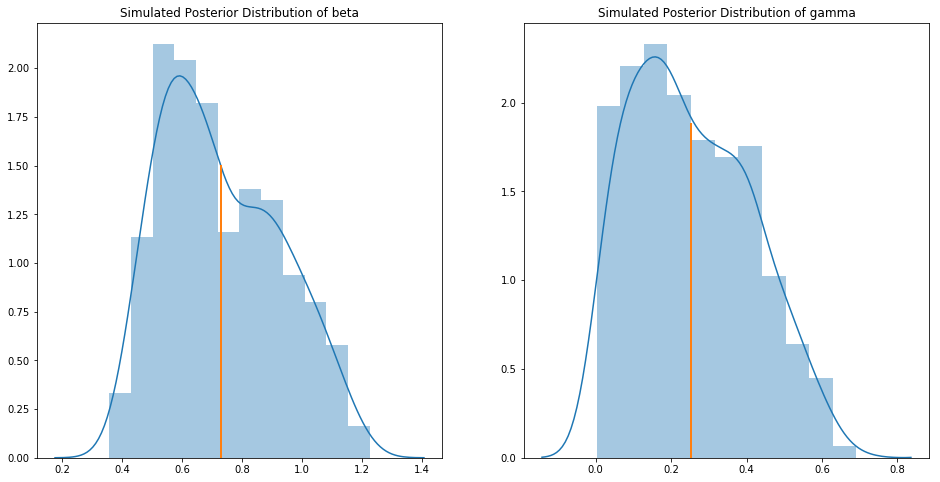

In [14]:
beta = OUT[:,0]
gamma = OUT[:,1]
plt.figure(figsize=(16,8))

plt.subplot(1,2, 1)
sns.distplot(a = beta, )
plt.plot([np.mean(beta), np.mean(beta)], [0, 1.5], linewidth=2)
plt.title('Simulated Posterior Distribution of beta')

plt.subplot(1,2, 2)
sns.distplot(gamma)
plt.plot([np.mean(gamma), np.mean(gamma)], [0, 1.88], linewidth=2)
plt.title('Simulated Posterior Distribution of gamma')
pass


In [ ]:
def House_COUP(Xdata,epsil,lambda_L,k):
    """Partially coupled ABC algorithm for household epidemics
    lambda_L is drawn from the prior (or however)
    Code finds lambda_G values consistent with the data
    Input: Xdata - Epidemic data to compare simulations with.
    epsil - Max distance between simulated and observed final size for a simulation 
    to be accepted. (Tighter control on distance after simulations straightforward).
    lambda_L - local infection (household) rate
    k - Gamma(k,k) infectious period with k=0 a constant infectious period."""
    hsA = np.sum(Xdata, axis = 0) # hsA[i] - Number of households of size i
    isA = np.sum(Xdata, axis = 1) # isA[i] - Number of households with i-1 infectives
    colA = np.arange(1, hsA.shape[0]+1)
    rowA = np.arange(0, hsA.shape[0]+1)
    
    xA = np.sum(isA*rowA) # Final size
    HH = hsA.shape[0] # HH maximum household size
    ks = np.arange(1, HH+1)
    
    n = np.repeat(ks, hsA)
    m = n.shape[0]# Number of households
    N = np.sum(n) # Population size
    NS = N.copy() # Number of susceptibles
    sev=0       # Running tally of severity (sum of infectious periods)
    threshold=0 # Running tally of (global) threshold required for the next infection
    
    ni = np.repeat(0, n.size) # infectives (per household)
    ns = n.copy() # susceptibles (per household)
    
    OUT = np.zeros((HH+1, HH))
    OUT[0, :] = hsA # Epidemic data in the same form as Xdata
                   # Start with everybody susceptible
    
    DISS = np.zeros((2*epsil+1, 5)) # Matrix for collecting epidemics infecting within epsil of xA infectives.
    SEVI = np.zeros((N, 3)) # Matrix to keep track of number of infectives, severity and threshold.
    ys=0    # number of infectives
    count=0 # number of global infections taking place. First global infection is the introductory case. 
    
    while ys<=(xA+epsil):
        # Only need to consider the epidemic until xA+epsil infections occur.
        # We simulate successive global infections (should they occur) with associated
        # local (within household epidemics)
        # For the count+1 global infection to take place, we require that 
        # for k=1,2,..., count;  lambda_G * severity from first k infectives is larger
        # than the k^th threshold
        count+=1
        kk = np.random.choice(m, 1, p = ns/ns.sum(), replace = True)[0]
        OUT[ni[kk-1],n[kk-1]-1]=OUT[ni[kk-1],n[kk-1]-1]-1
        hou_epi=House_epi(ns[kk-1],k,lambda_L)# Simulate a household epidemic among the remaining susceptibles in the household
        
        ns[kk-1]-=hou_epi[0]
        ni[kk-1] = n[kk-1] - ns[kk-1]#update household kk data (susceptibles and infectives)
        
        OUT[ni[kk-1],n[kk-1]-1]+=1# Update the state of the population following the global 
        #infection and resulting household epidemic
        NS = ns.sum()
        threshold+=np.random.exponential(size = 1, scale = (N/NS))
        
        ys+=hou_epi[0]
        sev+=hou_epi[1]
        if count<=N:
            SEVI[count-1,:] = [ys,sev,threshold]
        # If the number infected is close to xA, we check what value of lambda_G 
        # would be needed for an epidemic of the desired size. 
        # Note that in many cases no value of lambda_G will result in an epidemic 
        # close to xA. 
        if abs(ys-xA)<=epsil:
            dist = np.sum(abs(OUT-Xdata))
            TT = SEVI[0:count, 2]/SEVI[0:count, 1] #ratio of threshold to severity
            Tlow = max(TT[0:(count-1)])
            Thi=TT[0:count].max()   #  Thi is the maximum lambda_G which leads to at most count global infections
            DISS[ys-(xA-epsil), :] = [1,dist,abs(ys-xA),Tlow,Thi]
            
    return DISS


In [43]:
print(House_COUP(DATA, 24, 3, 1))

[[  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  1.         138.          22.           0.52716447   0.52716447]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  1.         138.          19.           0.52716447   0.52716447]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  1.         138.          15.           0.52716447   0.52716447]
 [  0.           0.           0.           0.           0.        ]
 [  1.         138.          13.           0.52716447   0.52716447]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  1.         138.          10.           0.527